In [25]:
# https://nextjournal.com/gkoehler/pytorch-mnist

In [26]:
import torch
import torchvision
import pandas as pd

In [27]:
# define model parameters
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

# set seeds for reproducibility
random_seed = 1
torch.backends.cudnn.enabled = False # uses non-deterministic algorithms
torch.manual_seed(random_seed)

In [28]:
# init data loaders
train_data = torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)

test_data = torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

In [29]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [30]:
example_data.shape

torch.Size([1000, 1, 28, 28])

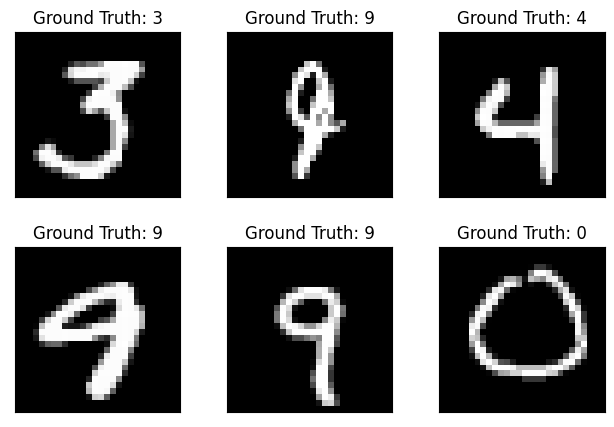

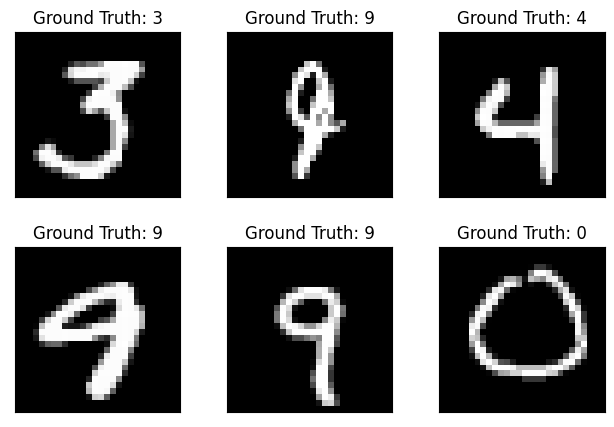

In [31]:
# plot 6 examples of test data
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [32]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [33]:
# define model architecture
# (nice way to build a network in PyTorch is to create a class that inherits from nn.Module)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, 10) 

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

# Broadly speaking we can think of the torch.nn layers as which contain trainable 
# parameters while torch.nn.functional are purely functional. 

In [34]:
# init network and optimizer
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
# Note: If we were using a GPU for training, we should have also sent the 
# network parameters to the GPU using e.g. network.cuda(). 
# It is important to transfer the network's parameters to the appropriate 
# device before passing them to the optimizer, otherwise the optimizer will 
# not be able to keep track of them in the right way.

In [35]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [36]:
# define training loop function
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [37]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [38]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/tmp/ipykernel_18484/2129092341.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/reese/.local/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325928
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.287777
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.281435
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.243744
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.264606
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.240564
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.153203
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.211479
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.056642
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.010619
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.008978
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.867195
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.755029
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.617570
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.411560
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.595001
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.259282
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.326851
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.236279
Train Epoch: 1 [12160/6

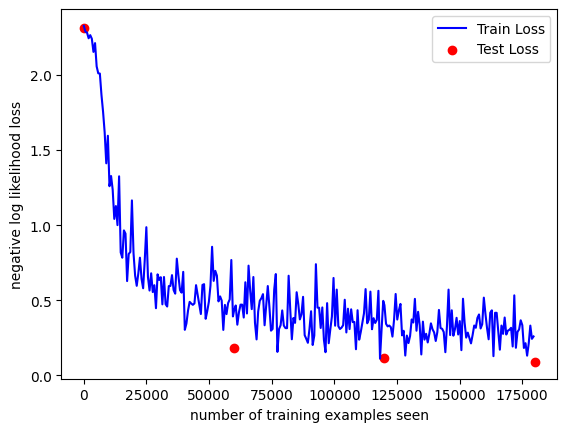

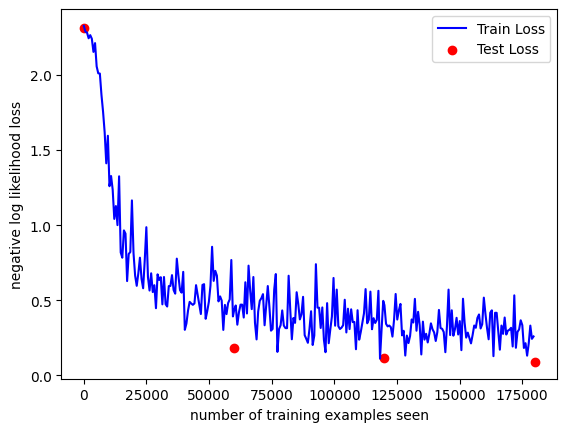

In [39]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [40]:
# continue training from saved model
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

network_state_dict = torch.load("./results/model.pth")
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load("./results/model.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)

for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

KeyError: 'param_groups'